In [1]:
import pandas as pd
import numpy as np
import shutil
import os
import random
from PIL import Image
from datasets import load_dataset

In [2]:
plots = pd.read_json("../data/annotations.json")

print("Plots Dataset size :", len(plots))
plots.head()

Plots Dataset size : 33657


,models,type,general_figure_info,image_index
0,"[{'name': 'Goods and services', 'color': '#F0E...",dot_line,{'title': {'text': 'Payments made towards prim...,0
1,"[{'name': 'Arms exports', 'color': '#FFFF00', ...",dot_line,{'title': {'text': 'Arm exports and imports in...,1
2,"[{'name': 'Infant', 'color': '#191970', 'label...",dot_line,{'title': {'text': 'Mortality rates in Marshal...,2
3,"[{'name': 'Female', 'color': '#D2B48C', 'label...",dot_line,{'title': {'text': 'Percentage of repeaters in...,3
4,"[{'name': 'US$', 'color': '#B8860B', 'label': ...",dot_line,{'title': {'text': 'Total resource balance of ...,4


In [6]:
plots["type"].value_counts()


type
hbar_categorical    11292
vbar_categorical    11242
dot_line             5574
line                 5549
Name: count, dtype: int64

**Filtro el dataset para quedarme con las visualizaciones single-plot, elimino los hbar plots y renombro los tipos**

In [9]:
single_plots = plots[plots['models'].apply(lambda x: len(x) == 1)].copy()
single_plots.loc[:, "type"] = single_plots["type"].map({"dot_line": "circle", "vbar_categorical": "bar", "line": "line", "hbar_categorical": "hbar"})
single_plots = single_plots.dropna(subset=["type"])

print("Single-plots Dataset size :", len(single_plots))
single_plots.head()

Single-plots Dataset size : 6070


,models,type,general_figure_info,image_index
4435,"[{'name': 'Secure Internet servers', 'color': ...",circle,{'title': {'text': 'Number of secure servers i...,4435
4436,"[{'name': 'Communications', 'color': '#FFA07A'...",circle,"{'y_axis': {'minor_ticks': {'values': [0, 1, 2...",4436
4437,"[{'name': 'Armed forces personnel', 'color': '...",circle,{'title': {'text': 'Total onduty military pers...,4437
4438,[{'name': 'Government expenditure per tertiary...,circle,{'title': {'text': 'Government expenditure per...,4438
4439,"[{'name': 'Tax payments', 'color': '#6B8E23', ...",circle,"{'y_axis': {'minor_ticks': {'values': [0, 1, 2...",4439


In [ ]:
def var_type(var):

    try:
        int(var)
        return "temporal"
    except:
        return "nominal"

def get_vega(df, index, vega_structure = True):
    
    ''' Get vega code from a PlotQA DataFrame entry at index '''

    mark_type = df["type"][index]

    x_name = df["general_figure_info"][index]["x_axis"]["label"]["text"]
    y_name = df["general_figure_info"][index]["y_axis"]["label"]["text"]

    y_values = [np.round(y, 2) for y in df["models"][index][0]["y"]]
    
    x_values = single_plots["general_figure_info"][index]["x_axis"]["major_labels"]["values"]
    x_values_new = []
    
    for x_val in x_values:
        if isinstance(x_val, str):
            if x_val.find("'") != -1: x_val = x_val.replace("'","")

        x_values_new.append(x_val)

    x_values = x_values_new    

    midpoint = len(x_values) // 2
    x_values = x_values[:midpoint]

    x_type = var_type(x_values[0])

    vega = None

    if vega_structure:

        vega = {"mark": mark_type,
                "encoding": {
                    "x": {"field": x_name, "type": x_type},
                    "y": {"field": y_name, "type": "quantitative"}
                },
                "data": {
                    "values": [
                        {"x": x, "y": y} for x,y in zip(x_values, y_values)
                    ]
                }
            }
    else:
        vega = mark_type + "|" + x_type + "|" + x_name + "|" + "quantitative" + "|" + y_name

    return vega

In [28]:
index = single_plots.sample().index[0]
get_vega(single_plots, index)

{'mark': 'bar',
 'encoding': {'x': {'field': 'Country', 'type': 'nominal'},
  'y': {'field': '% of women ages 15-49', 'type': 'quantitative'}},
 'data': {'values': [{'x': 'Japan', 'y': 64.5},
   {'x': 'Kuwait', 'y': 34.6},
   {'x': 'Mali', 'y': 4.7},
   {'x': 'Mexico', 'y': 52.7},
   {'x': 'Morocco', 'y': 35.9},
   {'x': 'Paraguay', 'y': 44.8}]}}

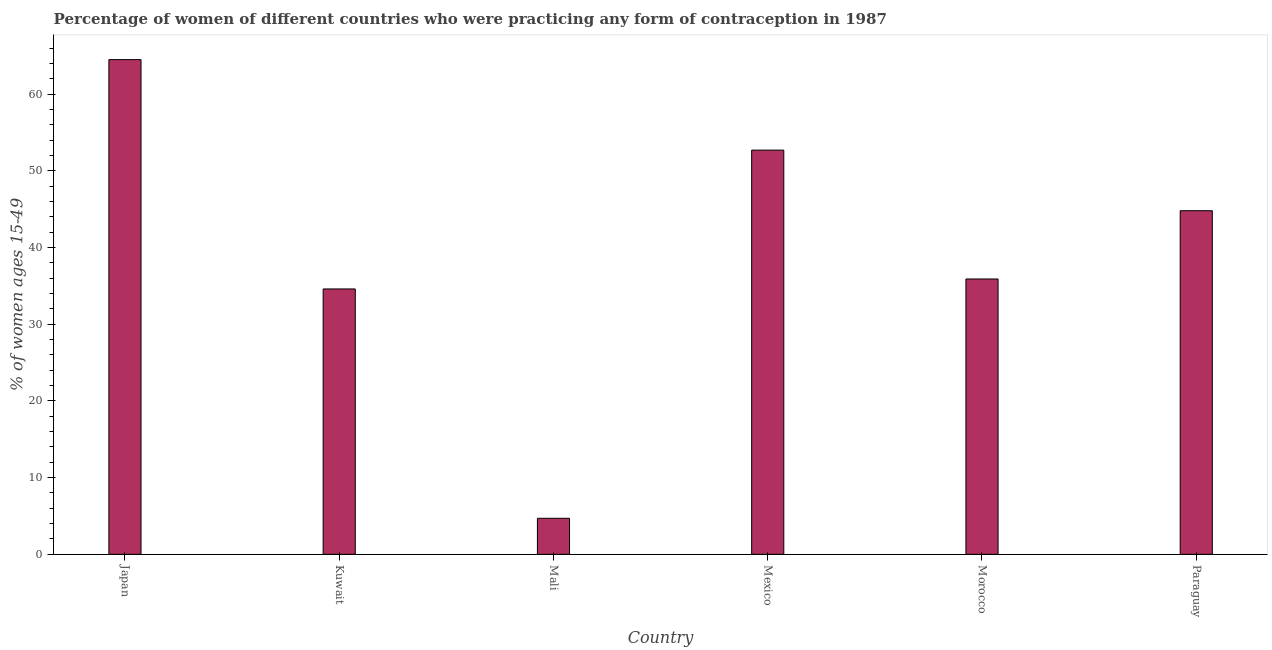

In [29]:
Image.open("../plotqa/png/"+ str(index) +".png")

In [30]:
def erase_files(path):

    for filename in os.listdir(path):

        file_path = os.path.join(path, filename)

        try:
            if os.path.isfile(file_path): os.remove(file_path)
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")

def copy_file(filename, src_dir, dest_dir):
    
    source_path = os.path.join(src_dir, filename)
    destination_path = os.path.join(dest_dir,filename)

    if os.path.exists(source_path):
        try:
            shutil.copy(source_path, destination_path)
        except IOError as e:
            print(f"Failed to copy {filename}: {e}")
    else:
        print(f"File {filename} does not exist in the source directory.")

def generate_split(path, df, indexes):
    
    print("generating slice of size ", len(indexes))
    erase_files(path)

    metadata = [['file_name','text']]

    for i in indexes:
        
        copy_file(str(i) + ".png", "../plotqa/png", path)

        vega_str = '"' + str(get_vega(df, i, False)) + '"'
        metadata.append([str(i) + ".png", vega_str])

    np.savetxt(path + "/metadata.csv", metadata, delimiter = ',', fmt = '% s')

def generate_dataset(path, df, n_samples):
    
    np.random.seed(42)
    random.seed(42)

    n_train = n_samples
    n_val = int(n_samples * 0.02)
    n_test = int(n_samples * 0.1)

    indexes = list(df.sample(n_train + n_val + n_test).index)

    generate_split(path + "/train", df, indexes[:n_train])
    generate_split(path + "/val", df, indexes[n_train:n_train+n_val])
    generate_split(path + "/test", df, indexes[n_train+n_val:])

**Dataset Generation**

In [31]:
dataset_name = "plotqa_simple"
generate_dataset("datasets/" + dataset_name, single_plots, n_samples = 1000)

generating slice of size  1000
generating slice of size  20
generating slice of size  100


**Upload to Huggingface**

In [32]:
dataset = load_dataset("imagefolder", data_dir = "datasets/" + dataset_name)
dataset.push_to_hub("martinsinnona/" + dataset_name)

Resolving data files:   0%|          | 0/1001 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/101 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/martinsinnona/plotqa_simple/commit/3aad204aef1712a5e21498ec7d5bde0693c55e9a', commit_message='Upload dataset', commit_description='', oid='3aad204aef1712a5e21498ec7d5bde0693c55e9a', pr_url=None, pr_revision=None, pr_num=None)

In [33]:
x_types = {"quantitative":0, "temporal":0, "nominal":0, "ordinal":0}
y_types = {"quantitative":0, "temporal":0, "nominal":0, "ordinal":0}

for i in single_plots.index:

    vega = get_vega(single_plots, i)

    x_types[ vega["encoding"]["x"]["type"] ] += 1
    y_types[ vega["encoding"]["y"]["type"] ] += 1

print(x_types)
print(y_types)

{'quantitative': 0, 'temporal': 3392, 'nominal': 787, 'ordinal': 0}
{'quantitative': 4179, 'temporal': 0, 'nominal': 0, 'ordinal': 0}
